In [1]:
import pandas as pd
import numpy as np

In [2]:
%%file k562.vs.hct116.atac-seq.samples.txt
cell_type replicate bam_url
k562 1 https://www.encodeproject.org/files/ENCFF512VEZ/@@download/ENCFF512VEZ.bam
k562 2 https://www.encodeproject.org/files/ENCFF987XOV/@@download/ENCFF987XOV.bam
hct116 1 https://www.encodeproject.org/files/ENCFF724QHH/@@download/ENCFF724QHH.bam
hct116 2 https://www.encodeproject.org/files/ENCFF927YUB/@@download/ENCFF927YUB.bam

Overwriting k562.vs.hct116.atac-seq.samples.txt


In [3]:
samplesheet_filepath = 'k562.vs.hct116.atac-seq.samples.txt'
samplesheet_sep = ' '

In [4]:
samplesheet_df = pd.read_csv(samplesheet_filepath, sep = samplesheet_sep)
samplesheet_df

,cell_type,replicate,bam_url
0,k562,1,https://www.encodeproject.org/files/ENCFF512VE...
1,k562,2,https://www.encodeproject.org/files/ENCFF987XO...
2,hct116,1,https://www.encodeproject.org/files/ENCFF724QH...
3,hct116,2,https://www.encodeproject.org/files/ENCFF927YU...


In [5]:
samplesheet_df['basename'] = samplesheet_df['cell_type'] + '_rep' + samplesheet_df['replicate'].astype(str)
samplesheet_df['bam_filepath'] = samplesheet_df['basename'] + '.bam'

In [6]:
samplesheet_df['wget_bam_cmd'] = (
    'wget -nc -O ' +
    samplesheet_df['bam_filepath'] + ' ' +
    '"' + samplesheet_df['bam_url'] + '"'
)

In [7]:
%%time

run_wget_bam_cmds = run_cmd = True
for cmd in list(samplesheet_df['wget_bam_cmd']):
    print(cmd)
    if run_cmd:
        ! {cmd}

wget -nc -O k562_rep1.bam "https://www.encodeproject.org/files/ENCFF512VEZ/@@download/ENCFF512VEZ.bam"
File ‘k562_rep1.bam’ already there; not retrieving.
wget -nc -O k562_rep2.bam "https://www.encodeproject.org/files/ENCFF987XOV/@@download/ENCFF987XOV.bam"
File ‘k562_rep2.bam’ already there; not retrieving.
wget -nc -O hct116_rep1.bam "https://www.encodeproject.org/files/ENCFF724QHH/@@download/ENCFF724QHH.bam"
File ‘hct116_rep1.bam’ already there; not retrieving.
wget -nc -O hct116_rep2.bam "https://www.encodeproject.org/files/ENCFF927YUB/@@download/ENCFF927YUB.bam"
File ‘hct116_rep2.bam’ already there; not retrieving.
CPU times: user 6.15 ms, sys: 18.2 ms, total: 24.4 ms
Wall time: 460 ms


In [8]:
samplesheet_df['tagdir_filepath'] = (
    samplesheet_df['basename'] + '.tagdir/'
)

In [9]:
samplesheet_df['tagdir_cmd'] = (
    'mkdir -p '+ samplesheet_df['tagdir_filepath'] + '; ' +
    'makeTagDirectory ' + ' ' + 
    samplesheet_df['tagdir_filepath'] + ' ' +
    samplesheet_df['bam_filepath'] + ' ' +
    '-single '
)

In [10]:
%%time

run_tagdir_cmds = run_cmd = True
for cmd in list(samplesheet_df['tagdir_cmd']):
    print(cmd)
    if run_cmd:
        ! {cmd}

mkdir -p k562_rep1.tagdir/; makeTagDirectory  k562_rep1.tagdir/ k562_rep1.bam -single 
	Will parse file: k562_rep1.bam

	Creating directory: k562_rep1.tagdir/ and removing existing *.tags.tsv

	Treating k562_rep1.bam as a bam file
	Reading alignment file k562_rep1.bam

	Optimizing tag files...
	Optimizing single genome.tags.tsv file...
	Estimated genome size = 3096471864
	Total Tags = 25070970.0
	Total Positions = 44510782
	Average tag length = 91.6
	Median tags per position = 0 (ideal: 1)
	Average tags per position = 0.089
	Fragment Length Estimate: 429
	Peak Width Estimate: 0
		!!! No reliable estimate for peak size
		Setting Peak width estimate to be equal to fragment length estimate
	Autocorrelation quality control metrics:
		Same strand fold enrichment: 2.7
		Diff strand fold enrichment: 3.0
		Same / Diff fold enrichment: 1.0

		Guessing sample is ChIP-Seq or unstranded RNA-Seq - autocorrelation looks good.

mkdir -p k562_rep2.tagdir/; makeTagDirectory  k562_rep2.tagdir/ k562_rep2

In [11]:
samplesheet_df['sample'] = True

In [12]:
group_1  = 'k562'
group_2  = 'hct116'

group_column = 'cell_type'
sample_column = 'sample'
sort_column = 'replicate'

comparison_prefix = f'{group_1}.vs.{group_2}'


In [13]:

sample_subset_df = samplesheet_df[samplesheet_df[sample_column]].sort_values(by = sort_column).copy()
group_1_sample_tagdir_filepaths = list(sample_subset_df[sample_subset_df[group_column] == group_1]['tagdir_filepath'])
group_2_sample_tagdir_filepaths = list(sample_subset_df[sample_subset_df[group_column] == group_2]['tagdir_filepath'])
sample_tagdir_filepaths = group_1_sample_tagdir_filepaths + group_2_sample_tagdir_filepaths
group_1_sample_tagdir_filepaths_str = ' '.join(group_1_sample_tagdir_filepaths)
group_2_sample_tagdir_filepaths_str = ' '.join(group_2_sample_tagdir_filepaths)
sample_tagdir_filepaths_str = ' '.join(sample_tagdir_filepaths)

input_subset_df = samplesheet_df[samplesheet_df[sample_column] == False].sort_values(by = sort_column).copy()
group_1_input_tagdir_filepaths = list(input_subset_df[input_subset_df[group_column] == group_1]['tagdir_filepath'])
group_2_input_tagdir_filepaths = list(input_subset_df[input_subset_df[group_column] == group_2]['tagdir_filepath'])
input_tagdir_filepaths = group_1_input_tagdir_filepaths + group_2_input_tagdir_filepaths
input_tagdir_filepaths_str = ' '.join(input_tagdir_filepaths)

In [14]:
min_raw = 7

In [15]:
tagdirs_opt = f'-d {sample_tagdir_filepaths_str}'
input_tagdirs_opt = ' ' if (len(input_tagdir_filepaths) == 0) else f'-dinput {input_tagdir_filepaths_str}'

In [16]:
tss_filepath = f'{comparison_prefix}.tss.min_raw_{min_raw}.txt'

get_tss_cmd = (
    f'perl getTSSfromReads.noLib.pl '
    f'{tagdirs_opt} '
    f'{input_tagdirs_opt} '
    f'-minRaw {min_raw} '
    f'> {tss_filepath}'
)


In [17]:
%%time

run_get_tss_cmd = True
for cmd in [get_tss_cmd]:
    print(cmd)
    if run_get_tss_cmd:
        ! {cmd}

perl getTSSfromReads.noLib.pl -d k562_rep1.tagdir/ k562_rep2.tagdir/ hct116_rep1.tagdir/ hct116_rep2.tagdir/   -minRaw 7 > k562.vs.hct116.tss.min_raw_7.txt
	Will analyze TagDir: k562_rep1.tagdir/
	Will analyze TagDir: k562_rep2.tagdir/
	Will analyze TagDir: hct116_rep1.tagdir/
	Will analyze TagDir: hct116_rep2.tagdir/
	Setting minimum raw read threshold to "7"
	Using threshold of 7
	Processing k562_rep1.tagdir/ (25070970.0, scaleFactor=0.398867694389168)
		k562_rep1.tagdir//genome.tags.tsv
	Finished k562_rep1.tagdir/

	Processing k562_rep2.tagdir/ (23222755.0, scaleFactor=0.430612130214524)
		k562_rep2.tagdir//genome.tags.tsv
	Finished k562_rep2.tagdir/

	Processing hct116_rep1.tagdir/ (26201497.0, scaleFactor=0.381657582389281)
		hct116_rep1.tagdir//genome.tags.tsv
	Finished hct116_rep1.tagdir/

	Processing hct116_rep2.tagdir/ (29330800.0, scaleFactor=0.340938535600802)
		hct116_rep2.tagdir//genome.tags.tsv
	Finished hct116_rep2.tagdir/

	0 of 161150 filtered by input overall
	TotalPo

In [18]:
genome_fa_filepath = 'hg38.fa'
genome_fai_filepath = f'{genome_fa_filepath}.fai'
genome_chromsizes_filepath = f'{genome_fa_filepath}.chromsizes.tab'
genome_fa_gz_url = 'https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/latest/hg38.fa.masked.gz'

In [19]:
download_genome_fa_cmd = f'wget -nc -O {genome_fa_filepath}.gz "{genome_fa_gz_url}"; zcat {genome_fa_filepath}.gz > {genome_fa_filepath}'

In [42]:
index_genome_fa_cmd = f'samtools faidx {genome_fa_filepath}'
genome_chromsizes_cmd = f'cut -f1,2 {genome_fai_filepath} > {genome_chromsizes_filepath}'

In [43]:
%%time

run_download_genome_fa_cmd = run_cmd = True
for cmd in [download_genome_fa_cmd, index_genome_fa_cmd, genome_chromsizes_cmd]:
    print(cmd)
    if run_cmd:
        ! {cmd}

wget -nc -O hg38.fa.gz "https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/latest/hg38.fa.masked.gz"; zcat hg38.fa.gz > hg38.fa
File ‘hg38.fa.gz’ already there; not retrieving.
samtools faidx hg38.fa
CPU times: user 255 ms, sys: 63.8 ms, total: 319 ms
Wall time: 29 s


In [21]:
counts_filepath = tss_filepath[:-len('.txt')]+'.counts.txt'
counts_cmd = (
    f'annotatePeaks.pl {tss_filepath} '
    f'{genome_fa_filepath} '
    f'-strand + -fragLength 1 -raw '
    f'-d {sample_tagdir_filepaths_str} '
    f'> {counts_filepath}'
)

In [22]:
%%time

run_counts_cmd = run_cmd = True
for cmd in [counts_cmd]:
    print(cmd)
    if run_cmd:
        ! {cmd}

annotatePeaks.pl k562.vs.hct116.tss.min_raw_7.txt hg38.fa -strand + -fragLength 1 -raw -d k562_rep1.tagdir/ k562_rep2.tagdir/ hct116_rep1.tagdir/ hct116_rep2.tagdir/ > k562.vs.hct116.tss.min_raw_7.counts.txt

	Using Custom Genome
	Peak file = k562.vs.hct116.tss.min_raw_7.txt
	Genome = hg38.fa
	Organism = unknown
	Will count tags on strand: +
	Fragment Length set to 1
	Will NOT normalize tag counts
	Tag Directories:
		k562_rep1.tagdir/
		k562_rep2.tagdir/
		hct116_rep1.tagdir/
		hct116_rep2.tagdir/
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 161150
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 161150
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Reading Positions...
	-----------------------
	Finding Closest TSS...
	Skipping T

In [23]:
tagdir_to_basename_lu = sample_subset_df.copy().set_index('tagdir_filepath')['basename'].to_dict()
tagdirs_to_basenames = lambda tagdirs: [tagdir_to_basename_lu[tagdir] for tagdir in tagdirs]
group_1_basenames = tagdirs_to_basenames(group_1_sample_tagdir_filepaths)
group_2_basenames = tagdirs_to_basenames(group_2_sample_tagdir_filepaths)

In [24]:
counts_df = pd.read_csv(counts_filepath, sep = '\t')

counts_df_col_renames = {
    col: tagdir_to_basename_lu[col.split('/')[-2]+'/']
    for col
    in (
        list(counts_df.columns)
        [
            -len(
                group_1_basenames + group_2_basenames
            ):
        ]
    )
}
# counts_df_col_renames[list(counts_df.columns)[0]] = 'PeakID'
counts_df = counts_df.rename(columns = counts_df_col_renames)
counts_df

,PeakID (cmd=annotatePeaks.pl k562.vs.hct116.tss.min_raw_7.txt hg38.fa -strand + -fragLength 1 -raw -d k562_rep1.tagdir/ k562_rep2.tagdir/ hct116_rep1.tagdir/ hct116_rep2.tagdir/),Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,...,Nearest Refseq,Nearest Ensembl,Gene Name,Gene Alias,Gene Description,Gene Type,k562_rep1,k562_rep2,hct116_rep1,hct116_rep2
0,TSS-114218,chr17,22521366,22521366,+,66.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,66.0,62.5,44.5,46.0
1,TSS-153126,chr3,93470358,93470358,+,59.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,49.5,35.0,59.5,30.0
2,TSS-104962,chr17,22521383,22521383,+,57.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,57.5,55.0,34.0,32.0
3,TSS-44347,chr19,6517033,6517033,-,56.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,17.0,18.0,32.5,56.5
4,TSS-120674,chr8,143977302,143977302,-,55.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,19.5,18.0,50.0,55.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161145,TSS-50151,chr6,63635876,63635876,-,7.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.5,4.0,5.0,7.0
161146,TSS-63877,chr1,155127880,155127880,-,7.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2.5,5.5,7.0
161147,TSS-108837,chr17,47941428,47941428,+,7.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7.0,3.5,5.0,4.5
161148,TSS-104044,chr17,16438646,16438646,+,7.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,6.5,7.0


In [25]:
differential_filepath = counts_filepath[:-len('.txt')]+f'.differential.txt'

In [26]:
basename_to_group_codes = sample_subset_df.copy().set_index('basename')[group_column].to_dict()

group_codes = [basename_to_group_codes[basename] for basename in (group_1_basenames + group_2_basenames)]

group_codes_str = ' '.join(map(str, group_codes))


In [27]:
differential_expression_cmd = (
    f'getDiffExpression.pl {counts_filepath} '
    f'{group_codes_str} '
    f'> {differential_filepath}'
)


In [28]:
%%time

run_differential_expression_cmd = run_cmd = True
for cmd in [differential_expression_cmd]:
    print(cmd)
    if run_cmd:
        ! {cmd}

getDiffExpression.pl k562.vs.hct116.tss.min_raw_7.counts.txt k562 k562 hct116 hct116 > k562.vs.hct116.tss.min_raw_7.counts.differential.txt
	Autodetecting input file format...
	Autodetected annotatePeaks.pl file

	Performing variance stabalization (rlog)...



	Using DESeq2 to calculate differential expression/enrichment...
	Output Stats k562 vs. hct116:
		Total Genes: 161150
		Total Up-regulated in hct116 vs. k562: 46 (0.029%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in hct116 vs. k562: 748 (0.464%) [log2fold<-1, FDR<0.05]

CPU times: user 646 ms, sys: 129 ms, total: 775 ms
Wall time: 1min 9s


In [29]:
! head {differential_filepath}

PeakID (cmd=annotatePeaks.pl k562.vs.hct116.tss.min_raw_7.txt hg38.fa -strand + -fragLength 1 -raw -d k562_rep1.tagdir/ k562_rep2.tagdir/ hct116_rep1.tagdir/ hct116_rep2.tagdir/) (cmd=getDiffExpression.pl k562.vs.hct116.tss.min_raw_7.counts.txt k562 k562 hct116 hct116)	Chr	Start	End	Strand	Peak Score	Focus Ratio/Region Size	Annotation	Detailed Annotation	Distance to TSS	Nearest PromoterID	Entrez ID	Nearest Unigene	Nearest Refseq	Nearest Ensembl	Gene Name	Gene Alias	Gene Description	Gene Type	k562_rep1.tagdir/ Tag Count in given bp (25070970.0 Total, normalization factor = 1, effective total = 10000000)	k562_rep2.tagdir/ Tag Count in given bp (23222755.0 Total, normalization factor = 1, effective total = 10000000)	hct116_rep1.tagdir/ Tag Count in given bp (26201497.0 Total, normalization factor = 1, effective total = 10000000)	hct116_rep2.tagdir/ Tag Count in given bp (29330800.0 Total, normalization factor = 1, effective total = 10000000)	k562 vs. hct116 Log2 Fold Change	k562 vs. hct11

In [30]:
differential_df = pd.read_csv(differential_filepath, sep = '\t')
differential_df = differential_df.rename(columns = {list(differential_df.columns)[0]:'PeakID'})
differential_df

,PeakID,Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,...,Gene Alias,Gene Description,Gene Type,"k562_rep1.tagdir/ Tag Count in given bp (25070970.0 Total, normalization factor = 1, effective total = 10000000)","k562_rep2.tagdir/ Tag Count in given bp (23222755.0 Total, normalization factor = 1, effective total = 10000000)","hct116_rep1.tagdir/ Tag Count in given bp (26201497.0 Total, normalization factor = 1, effective total = 10000000)","hct116_rep2.tagdir/ Tag Count in given bp (29330800.0 Total, normalization factor = 1, effective total = 10000000)",k562 vs. hct116 Log2 Fold Change,k562 vs. hct116 p-value,k562 vs. hct116 adj. p-value
0,TSS-79091,chr22,22559264,22559264,+,8.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.731609,2.817180,2.030905,1.858270,-2.423273,0.009977,0.185797
1,TSS-99886,chr13,48976472,48976472,+,8.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.060553,2.360068,2.464685,2.388557,0.654600,0.492034,0.896621
2,TSS-133456,chr14,23095408,23095408,+,12.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.643165,3.755335,3.130966,3.099580,-1.088756,0.071900,0.509644
3,TSS-44935,chr19,38336975,38336975,-,7.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.804478,1.721368,2.034024,1.617065,0.283973,0.797054,0.975132
4,TSS-82806,chr7,22083382,22083382,-,7.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.940739,1.724982,2.152900,2.086100,1.078442,0.334276,0.828736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161145,TSS-41217,chr19,58467016,58467016,-,8.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.312271,2.256137,2.321437,2.470788,0.345855,0.709051,0.961494
161146,TSS-119154,chr8,73293914,73293914,-,12.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.594006,2.778350,2.821036,2.927191,0.462041,0.557110,0.918670
161147,TSS-56458,chr1,44820230,44820230,-,17.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.956638,4.262717,3.857306,3.784726,-0.484216,0.354393,0.837580
161148,TSS-48771,chr6,159727141,159727141,+,10.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.157989,3.082030,2.382683,2.492447,-1.599657,0.036054,0.402027


In [31]:
differential_df['Name'] = differential_df['PeakID']
differential_df['log2fc'] = differential_df[list(differential_df.columns)[-4]]
differential_df['sum'] = differential_df['PeakID'].map(counts_df.copy().set_index(list(counts_df.columns)[0])[group_1_basenames + group_2_basenames].sum(axis = 1).to_dict())
# differential_df = differential_df[differential_df['sum']>=tss_min].copy().reset_index(drop = True)

differential_df['Score'] = differential_df['log2fc']

differential_df.sort_values('log2fc', ascending = False)

,PeakID,Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,...,"k562_rep2.tagdir/ Tag Count in given bp (23222755.0 Total, normalization factor = 1, effective total = 10000000)","hct116_rep1.tagdir/ Tag Count in given bp (26201497.0 Total, normalization factor = 1, effective total = 10000000)","hct116_rep2.tagdir/ Tag Count in given bp (29330800.0 Total, normalization factor = 1, effective total = 10000000)",k562 vs. hct116 Log2 Fold Change,k562 vs. hct116 p-value,k562 vs. hct116 adj. p-value,Name,log2fc,sum,Score
92629,TSS-119564,chr8,144472483,144472483,+,41.5,NaN,NaN,NaN,NaN,...,2.474528,4.589834,4.248970,6.968754,3.636142e-06,0.011986,TSS-119564,6.968754,76.5,6.968754
50001,TSS-157204,chr3,49358322,49358322,+,27.5,NaN,NaN,NaN,NaN,...,2.201858,3.729480,3.803250,6.360559,3.036833e-05,0.024914,TSS-157204,6.360559,50.0,6.360559
44114,TSS-150654,chr10,124152382,124152382,+,29.5,NaN,NaN,NaN,NaN,...,2.124421,3.372831,3.805005,6.229730,5.071632e-05,0.030642,TSS-150654,6.229730,46.0,6.229730
138524,TSS-111466,chr17,75721416,75721416,-,26.0,NaN,NaN,NaN,NaN,...,2.092834,3.391159,3.624738,6.141538,6.699893e-05,0.033973,TSS-111466,6.141538,44.0,6.141538
33314,TSS-103318,chr20,13995269,13995269,+,23.5,NaN,NaN,NaN,NaN,...,2.083521,3.660565,3.321451,6.129705,7.084254e-05,0.033973,TSS-103318,6.129705,42.5,6.129705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67920,TSS-78066,chr22,19397203,19397203,+,20.0,NaN,NaN,NaN,NaN,...,3.871587,1.870932,1.804516,-7.396939,1.133762e-06,0.006538,TSS-78066,-7.396939,37.0,-7.396939
24355,TSS-75376,chr22,19397211,19397211,-,21.5,NaN,NaN,NaN,NaN,...,3.818310,1.882115,1.815161,-7.430637,9.997967e-07,0.006196,TSS-75376,-7.430637,37.0,-7.430637
119057,TSS-79454,chr22,22557677,22557677,+,23.5,NaN,NaN,NaN,NaN,...,3.844398,1.909586,1.841445,-7.501927,7.600489e-07,0.005607,TSS-79454,-7.501927,39.5,-7.501927
31584,TSS-78632,chr22,22557685,22557685,-,21.0,NaN,NaN,NaN,NaN,...,4.038566,1.920753,1.852296,-7.511340,7.169945e-07,0.005554,TSS-78632,-7.511340,40.0,-7.511340


array([[<AxesSubplot:title={'center':'Score'}>]], dtype=object)

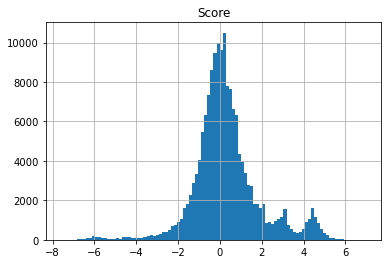

In [32]:
differential_bed_df = differential_df[['Chr', 'Start', 'End', 'Name', 'Score', 'Strand']].copy()
differential_bed_df[['Score']].hist(bins = 100)

In [33]:
differential_bed_filepath = differential_filepath[:-len('.txt')]+'.log2fc.bed'
differential_bed_df.to_csv(differential_bed_filepath, sep = '\t', index = False, header = None)
! head {differential_bed_filepath}

chr22	22559264	22559264	TSS-79091	-2.4232725889005	+
chr13	48976472	48976472	TSS-99886	0.654599558399933	+
chr14	23095408	23095408	TSS-133456	-1.08875645506917	+
chr19	38336975	38336975	TSS-44935	0.283973433169981	-
chr7	22083382	22083382	TSS-82806	1.07844155587258	-
chr10	74176682	74176682	TSS-150692	-0.914930804128	-
chr6	35259502	35259502	TSS-51295	0.144206567474984	-
chr8	142609176	142609176	TSS-122541	3.3345527876936094	+
chr1	155323517	155323517	TSS-71597	0.34315897874166995	-
chr7	155297720	155297720	TSS-87097	-1.13637470778481	+


In [34]:
cluster_slop = 200
clustered_bed_filepath = differential_bed_filepath[:-len('.bed')]+f'.cluster_slop_{cluster_slop}.bed'
cluster_cmd = f'bedtools sort -i {differential_bed_filepath} | bedtools cluster -s -d {cluster_slop} > {clustered_bed_filepath}'


In [35]:
%%time

run_cluster_cmd = run_cmd = True
for cmd in [cluster_cmd]:
    print(cmd)
    if run_cmd:
        ! {cmd}

bedtools sort -i k562.vs.hct116.tss.min_raw_7.counts.differential.log2fc.bed | bedtools cluster -s -d 200 > k562.vs.hct116.tss.min_raw_7.counts.differential.log2fc.cluster_slop_200.bed
CPU times: user 10.7 ms, sys: 6.7 ms, total: 17.4 ms
Wall time: 1.16 s


In [36]:
clustered_differential_bed_df = pd.read_csv(clustered_bed_filepath, sep = '\t', header = None, names = ['Chr', 'Start', 'End', 'Name', 'Score', 'Strand', 'Cluster'])
clustered_differential_bed_df

,Chr,Start,End,Name,Score,Strand,Cluster
0,chr1,629907,629907,TSS-67026,-1.523196,+,1
1,chr1,629910,629910,TSS-58969,-0.915029,+,1
2,chr1,629911,629911,TSS-57893,-1.404528,+,1
3,chr1,629912,629912,TSS-56733,-1.502870,+,1
4,chr1,629913,629913,TSS-73246,-2.118058,+,1
...,...,...,...,...,...,...,...
161145,chrX,155216920,155216920,TSS-125367,0.345855,-,43263
161146,chrX,155613027,155613027,TSS-125693,0.260380,-,43264
161147,chrX,155881320,155881320,TSS-125609,-0.196981,-,43265
161148,chrX,155881361,155881361,TSS-125509,-0.612214,-,43265


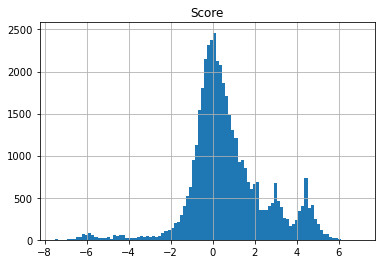

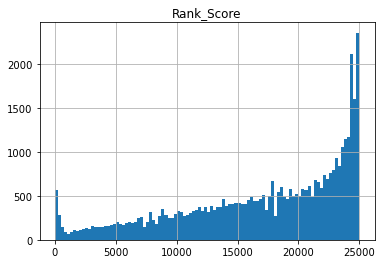

,Chr,Start,End,Name,Score,Strand,Cluster,Sum,Abs_Score,Rank_Score
0,chr1,629910,629910,TSS-58969,-0.915029,+,1,83.5,0.915029,6471.0
1,chr1,634015,634015,TSS-57606,-1.244631,+,2,110.0,1.244631,4469.0
2,chr1,778657,778657,TSS-66900,0.069618,+,3,57.5,0.069618,16218.0
3,chr1,827476,827476,TSS-66607,-0.620749,+,4,23.5,0.620749,9100.0
4,chr1,842934,842934,TSS-59435,-6.000067,+,5,13.5,6.000067,86.0
...,...,...,...,...,...,...,...,...,...,...
43260,chrX,155027078,155027078,TSS-125223,-0.287185,-,43261,37.5,0.287185,12643.0
43261,chrX,155071429,155071429,TSS-126355,-0.218009,-,43262,38.5,0.218009,13365.0
43262,chrX,155216870,155216870,TSS-126376,-0.245965,-,43263,22.5,0.245965,13075.0
43263,chrX,155613027,155613027,TSS-125693,0.260380,-,43264,28.5,0.260380,17891.0


In [37]:
cluster_deduplicated_differential_bed_df = clustered_differential_bed_df.copy()
cluster_deduplicated_differential_bed_df['Sum'] = cluster_deduplicated_differential_bed_df['Name'].map(differential_df[['Name', 'sum']].copy().set_index('Name')['sum'].to_dict())
cluster_deduplicated_differential_bed_df['Abs_Score'] = cluster_deduplicated_differential_bed_df['Score'].abs()
cluster_deduplicated_differential_bed_df['Rank_Score'] = cluster_deduplicated_differential_bed_df['Score'].rank(method = 'dense')

dedup_sort_col = 'Sum'
dedup_sort_ascending = False

cluster_deduplicated_differential_bed_df = (
    cluster_deduplicated_differential_bed_df
    .sort_values(by = ['Cluster', dedup_sort_col], ascending = [True, dedup_sort_ascending])
    .reset_index(drop = True)
    .copy()
    .drop_duplicates('Cluster')
    .reset_index(drop = True)
    .copy()
)
cluster_deduplicated_differential_bed_df[['Score']].hist(bins = 100)
plt.show()
cluster_deduplicated_differential_bed_df[['Rank_Score']].hist(bins = 100)
plt.show()
cluster_deduplicated_differential_bed_df

In [38]:
score_type = 'asis'
score_col = 'Score'
# score_type = 'rank'

In [39]:
if score_type == 'rank':
    score_col = 'Rank_Score'

In [40]:
cluster_deduplicated_differential_bed_filepath = clustered_bed_filepath[:-len('.bed')]+f'.cluster_deduplicated.score_type_{score_type}.bed'
cluster_deduplicated_differential_bed_df[['Chr', 'Start', 'End', 'Name', score_col, 'Strand']].to_csv(cluster_deduplicated_differential_bed_filepath, sep = '\t', index = False, header = None)
! head {cluster_deduplicated_differential_bed_filepath}

chr1	629910	629910	TSS-58969	-0.915029264755366	+
chr1	634015	634015	TSS-57606	-1.2446312541282	+
chr1	778657	778657	TSS-66900	0.0696183483530706	+
chr1	827476	827476	TSS-66607	-0.62074936969244	+
chr1	842934	842934	TSS-59435	-6.0000672301362	+
chr1	869878	869878	TSS-59487	-0.10508050122063	+
chr1	904749	904749	TSS-61453	-0.0954867668594599	+
chr1	921218	921218	TSS-60782	-0.172650683737087	+
chr1	940217	940217	TSS-64174	-1.03962121368226	+
chr1	941769	941769	TSS-66094	0.7550109768867479	+


In [44]:
slop = 200
mepp_filepath = cluster_deduplicated_differential_bed_filepath[:-len('.bed')]+f'.slop_{slop}.mepp'
motifs_filepath = 'homer.motifs.txt'
mepp_cmd = (
    f'bedtools slop -s -b {slop} -g {genome_fa_filepath}.fai -i {cluster_deduplicated_differential_bed_filepath} '
    f'|python -m mepp.get_scored_fasta -fi {genome_fa_filepath} '
    f'-bed - '
    f'|python -m mepp.cli '
    f'--fa - '
    f'--motifs {motifs_filepath} '
    f'--out {mepp_filepath} '
    f'--perms 200 '
    f'--batch 100 '
    f'--dgt 50 '
    f'--jobs 20 '
    f'--gjobs 10 '
    f'--nogpu '
    f'--dpi 100 '
    f'--orientations +,- '
    f'&> {mepp_filepath}.log'
)

In [45]:
%%time

run_mepp_cmd = run_cmd = True
for cmd in [mepp_cmd]:
    print(cmd)
    if run_cmd:
        ! {cmd}

bedtools slop -s -b 200 -g hg38.fa.fai -i k562.vs.hct116.tss.min_raw_7.counts.differential.log2fc.cluster_slop_200.cluster_deduplicated.score_type_asis.bed |python -m mepp.get_scored_fasta -fi hg38.fa -bed - |python -m mepp.cli --fa - --motifs homer.motifs.txt --out k562.vs.hct116.tss.min_raw_7.counts.differential.log2fc.cluster_slop_200.cluster_deduplicated.score_type_asis.slop_200.mepp --perms 200 --batch 100 --dgt 50 --jobs 20 --gjobs 10 --nogpu --dpi 100 --orientations +,- &> k562.vs.hct116.tss.min_raw_7.counts.differential.log2fc.cluster_slop_200.cluster_deduplicated.score_type_asis.slop_200.mepp.log
2022-01-24 15:03:35.349747: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/home/provnpd0/miniconda3/envs/jupyter-projects3/lib/python3.6/runpy.py:125: RuntimeWarning: 'mepp.get_scored_fasta' found in sys.modules after import of package 'mepp', but prior to execution of 'mepp.get_scored_fasta'; this may result in u

In [46]:
from IPython.display import display, Markdown


In [47]:

mepp_results_table_fwd_md = f'[Results table, + orientation]({mepp_filepath}/results_table_orientation_fwd.html)'
mepp_clustermap_fwd_md = f'[Clustermap, + orientation]({mepp_filepath}/clustermap_orientation_fwd.html)'

mepp_results_table_rev_md = f'[Results table, - orientation]({mepp_filepath}/results_table_orientation_rev.html)'
mepp_clustermap_rev_md = f'[Clustermap, - orientation]({mepp_filepath}/clustermap_orientation_rev.html)'

In [48]:
display(Markdown(mepp_results_table_fwd_md))
display(Markdown(mepp_clustermap_fwd_md))
display(Markdown(mepp_results_table_rev_md))
display(Markdown(mepp_clustermap_rev_md))

[Results table, + orientation](k562.vs.hct116.tss.min_raw_7.counts.differential.log2fc.cluster_slop_200.cluster_deduplicated.score_type_asis.slop_200.mepp/results_table_orientation_fwd.html)

[Clustermap, + orientation](k562.vs.hct116.tss.min_raw_7.counts.differential.log2fc.cluster_slop_200.cluster_deduplicated.score_type_asis.slop_200.mepp/clustermap_orientation_fwd.html)

[Results table, - orientation](k562.vs.hct116.tss.min_raw_7.counts.differential.log2fc.cluster_slop_200.cluster_deduplicated.score_type_asis.slop_200.mepp/results_table_orientation_rev.html)

[Clustermap, - orientation](k562.vs.hct116.tss.min_raw_7.counts.differential.log2fc.cluster_slop_200.cluster_deduplicated.score_type_asis.slop_200.mepp/clustermap_orientation_rev.html)